In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# Reading the daatset
df = pd.read_csv('climate_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


##### Data Preprocessing

In [5]:
# Considering only the date & the temperature columns
data = df['date']
data = pd.DataFrame(data)
data = data.join(df['meantemp'])

In [6]:
# Converting the date field from object to datetime type
data['date'] = pd.to_datetime(data['date'])

# Resetting the index with the date
data = data.set_index(['date'])

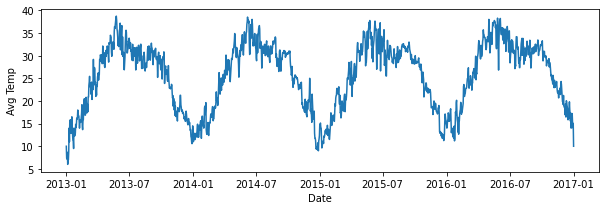

In [7]:
# Plotting the data
plt.figure(figsize = (10,3))
plt.xlabel('Date')
plt.ylabel('Avg Temp')
plt.plot(data)

##### Components of Time Series

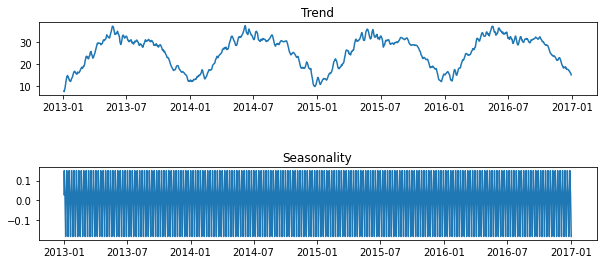

In [8]:
# Plotting the data to check for any trends or seasonality, if present
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_data = seasonal_decompose(data)

trend = decomposed_data.trend
seasonality = decomposed_data.seasonal

plt.figure(figsize = (10,4))

plt.subplot(2,1,1)
plt.title('Trend')
plt.plot(trend)

plt.subplot(2,1,2)
plt.title('Seasonality')
plt.plot(seasonality)

plt.subplots_adjust(hspace = 1)

##### Tests to check for stationarity of the data

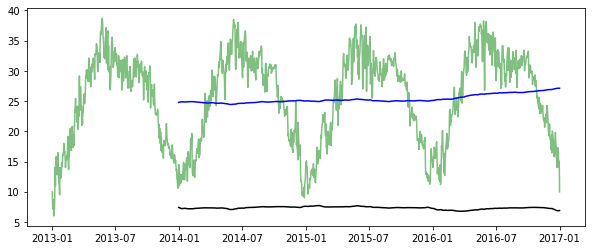

In [9]:
# Rolling Statistics Test
# Here, window size is taken as 365 as the data is taken on a daily basis

rolling_mean = data.rolling(window = 365).mean()
rolling_std = data.rolling(window = 365).std()

plt.figure(figsize = (10,4))
plt.plot(data,color = 'green',alpha = 0.5,label = 'Original data')
plt.plot(rolling_mean,color = 'blue', label = 'Rolling mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling deviation')

In [10]:
# Dickey Fuller Test
def ADF_Test(data):
    from statsmodels.tsa.stattools import adfuller

    test_data = adfuller(data)
    test_data_values = pd.Series(test_data[:4],index = ['Test Statistic Value','p value','Lags used','No of Observations'])
    for key,value in test_data[4].items():
        test_data_values['Critical value %s :' %key] = value

    print(test_data_values)

In [11]:
ADF_Test(data.dropna())
# Here p value < 0.5 but, Test Statistic > Critical values
# Therefore the data is not stationary

Test Statistic Value      -2.021069
p value                    0.277412
Lags used                 10.000000
No of Observations      1451.000000
Critical value 1% :       -3.434865
Critical value 5% :       -2.863534
Critical value 10% :      -2.567832
dtype: float64


##### Conversion to stationary data

In [12]:
# Applying differencing to the data
differenced_data = data['meantemp'] - data['meantemp'].shift(2) # Value of d is 2

In [13]:
ADF_Test(differenced_data.dropna())
# Here, the p value < 0.5 & the Test statistic value < Critical values 
# The data is now stationary

Test Statistic Value   -6.431565e+00
p value                 1.692368e-08
Lags used               2.400000e+01
No of Observations      1.435000e+03
Critical value 1% :    -3.434915e+00
Critical value 5% :    -2.863556e+00
Critical value 10% :   -2.567843e+00
dtype: float64


##### Plotting the ACF & PACF graph

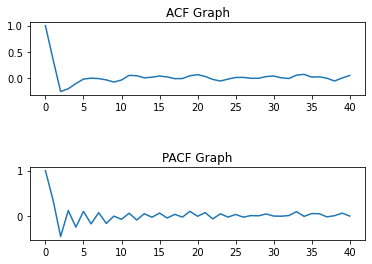

In [14]:
from statsmodels.tsa.stattools import acf,pacf

acf_graph = acf(differenced_data.dropna()) # Gives the value of q
pacf_graph = pacf(differenced_data.dropna()) # Gives the value of p

# Plotting the ACF & PACF graph
# Wherever the graph meets 0 in y-axis check the value in x-axis

plt.subplot(2,1,1)
plt.title('ACF Graph')
plt.plot(acf_graph)

plt.subplot(2,1,2)
plt.title('PACF Graph')
plt.plot(pacf_graph)

plt.subplots_adjust(hspace = 1)

# Value of p & q are approximately 2 from the graph

In [15]:
# Fitting the ARIMA model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data,order = (2,2,1)) # Substituting the values of p,d & q respectively
model = model.fit()

C:\Users\Varshith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Varshith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Varshith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [16]:
# Forecasting temperature for 2 years using the model built

result = model.forecast(750)

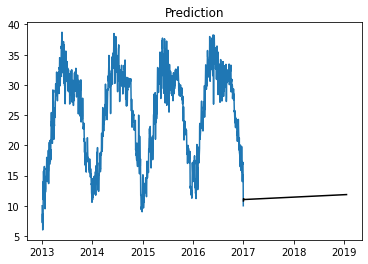

In [17]:
#
result = pd.DataFrame(result)
result.columns = ['meantemp']

plt.title('Prediction')
plt.plot(data)
plt.plot(result,color = 'black')